In [ ]:
!pip install mmf

     |████████████████████████████████| 409kB 8.4MB/s 
     |████████████████████████████████| 870kB 35.1MB/s 
     |████████████████████████████████| 1.5MB 48.2MB/s 
     |████████████████████████████████| 6.6MB 29.9MB/s 
     |██▉                             | 66.0MB 48.2MB/s eta 0:00:15
ERROR: Operation cancelled by user


In [ ]:
import torch

# registry is need to register our new model so as to be MMF discoverable
from mmf.common.registry import registry

# All model using MMF need to inherit BaseModel
from mmf.models.base_model import BaseModel

# Builder methods for image encoder and classifier
from mmf.utils.build import (
    build_classifier_layer,
    build_image_encoder,
    build_text_encoder,
)

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: ignored

## Implementing Custom Model

In [ ]:
import torch

## Setup CLIP

In [ ]:
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 90, done.
remote: Total 90 (delta 0), reused 0 (delta 0), pack-reused 90
Unpacking objects: 100% (90/90), done.


In [ ]:
pip install -e CLIP/

Obtaining file:///content/CLIP
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 12.8MB 244kB/s 
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=e8099ef8bebea5355553ea61fb9126162534da2f7fd1751efab87727a4ec56e2
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built ftfy
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Running setup.py develop for clip


In [ ]:
from CLIP.clip import *

In [ ]:
clip, clip_image_preprocess = load('ViT-B/32', jit=False)

100%|████████████████████████████████████████| 354M/354M [00:01<00:00, 204MiB/s]


# Implement Simple CLIP Model (Text + Image)

In [ ]:
import torch.nn as nn

class CLIPBaseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.clip = clip.eval()
    self.classifier = nn.Sequential(nn.Linear(1024, 768), 
                                    nn.ReLU(),
                                    nn.Linear(768, 1)).to('cuda')

  def forward(self, text, image):
    image_emb = clip.encode_image(image)
    text_emb = clip.encode_text(text)
    combined = (torch.cat([image_emb, text_emb], dim=1))
    # print(combined.shape)
    logits = self.classifier(combined)
    return logits
    

# Setup Infra. for training

## Dataset

In [ ]:
"""
Most of the source code is taken from
https://www.drivendata.co/blog/hateful-memes-benchmark/
"""
from torch.utils.data import Dataset
import pandas as pd
import torch
from PIL import Image


class HatefulMemesDataset(Dataset):

    def __init__(self, jsonl_path, path_to_img_dir,
                 image_transform, text_transform):
        """
        :param jsonl_path: path to jsonl provided by Facebook (e.g. data/train.jsonl
        :param path_to_img_dir: path to parent directory of img dir
        :param image_transform: torchvision.transforms.Compose
        :param text_transform: (texts: Union[str, List[str]]) -> torch.LongTensor
        """
        self.samples_frame = pd.read_json(jsonl_path, lines=True)
        self.samples_frame = self.samples_frame.reset_index(drop=True)
        self.samples_frame.img = self.samples_frame.apply(lambda row: (path_to_img_dir + '/' + row.img), axis=1)
        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        return len(self.samples_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_id = self.samples_frame.loc[idx, "id"]
        image = Image.open(self.samples_frame.loc[idx, "img"]).convert("RGB")
        image = self.image_transform(image)

        # TODO: Find a better way for reducing length of a sentence.
        # this is an actual sentence from the dataset:
        #
        # we only want to make you register them, restrict transfers, 
        # ban certain guns, limit magazine capacity, prohibit carrying them, 
        # ban or limit ammo, make other arbitrary laws, and, if we catch you 
        # violating any of these made-up rules, throw you in prison.... at 
        # which point we will take your guns!

        text = self.samples_frame.loc[idx, "text"]
        text = self.text_transform(text).squeeze()

        # case: development
        if "label" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "label"]]
            ).long().squeeze()
            sample = {
                "id": img_id,
                "image": image,
                "text": text,
                "label": label
            }
        else:
            # case: inference
            sample = {
                "id": img_id,
                "image": image,
                "text": text
            }

        return sample


## Trainer

In [ ]:
"""
Simple training loop
"""
import math
import logging
import itertools.chain

from tqdm.notebook import tqdm
import numpy as np

import torch

from torch.utils.data import DistributedSampler, DataLoader

from torch.cuda.amp import autocast

class Trainer:
    def __init__(self, model, loss_f, image_preprocess, text_preprocess, h, ckpt_path):
        """
        :param model: torch.Module(text, image) -> 0 or 1 (binary classification)
        :param loss_f: (model's output, target) -> a real number wrapped by torch.Tensor
        :param dictionary that contains the hyper-parameter values
        """
        self.model = model
        self.loss_f = loss_f
        self.h = h
        self.image_preprocess = image_preprocess
        self.text_preprocess = text_preprocess
        self.ckpt_path = ckpt_path

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model
        print("saving", self.ckpt_path)
        torch.save(raw_model.state_dict(), self.ckpt_path)

    def train(self, trainset_jsonl, trainset_image_dir_path, valset_jsonl, valset_image_dir_path):
        model, loss_f, h = self.model, self.loss_f, self.h
        optimizer = torch.optim.Adam(model.classifier.parameters(), h["lr"], h["betas"], h["eps"])
        train_dataset = HatefulMemesDataset(
            trainset_jsonl,
            trainset_image_dir_path,
            image_transform=self.image_preprocess,
            text_transform=self.text_preprocess)

        val_dataset = HatefulMemesDataset(
            valset_jsonl,
            valset_image_dir_path,
            image_transform=self.image_preprocess,
            text_transform=self.text_preprocess
        )

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()

        def run_epoch(split):
            is_train = split == 'train'
            model.classifier.train()
            data = train_dataset if is_train else val_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=h["batch_size"],
                                num_workers=h["num_workers"])

            losses = []
            num_correct_pred = 0
            num_pred = 0
            pbar = tqdm(enumerate(loader), total=len(loader), position=0, leave=True) if is_train else enumerate(loader)
            for it, batch in pbar:
                text = batch["text"]
                image = batch["image"]
                label = batch["label"]

                # place data on the correct device
                text = text.to(self.device)
                image = image.to(self.device)
                label = label.type(torch.LongTensor).to(self.device)

                with torch.set_grad_enabled(is_train):
                    with autocast():
                        output = model(text, image)
                        loss = loss_f(output, label)
                        losses.append(loss.item())

                if is_train:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    pbar.set_description(f"epoch {epoch + 1} iter {it}: train loss {loss.item():.5f}")

                if not is_train:
                    prediction = torch.argmax(output, dim=1)
                    num_correct_pred += torch.sum(prediction == label)
                    num_pred += prediction.shape[0]

            if not is_train:
                test_loss = float(np.mean(losses))
                acc = num_correct_pred / num_pred
                print("test loss:", test_loss)
                print("test accL", acc)
                return test_loss

        best_loss = float('inf')
        for epoch in range(h["max_epochs"]):
            run_epoch('train')
            if val_dataset is not None:
                test_loss = run_epoch('test')

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = val_dataset is None or test_loss < best_loss
            if self.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()

In [ ]:
import torch.nn.functional as F 


model = CLIPBaseline()
loss_f = nn.BCEWithLogitsLoss()
image_preprocess = clip_image_preprocess
text_preprocess = tokenize
h = {
  "lr": 0.001,
  "betas": [0.9, 0.998],
  "batch_size": 32,
  "num_workers": 2,
  "max_epochs": 32
}


trainer = Trainer(model, loss_f, image_preprocess, text_preprocess, h, "experiment_0")

## Data

In [ ]:
# Thank you Mario 🙏
from google.colab import drive
drive.mount('/gdrive')

!cp '/gdrive/MyDrive/MemesDeepLearning/dataFB.zip' '/content/data.zip'
!unzip -q data.zip

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
^C
[data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data.zip or
        data.zip.zip, and cannot find data.zip.ZIP, period.


In [ ]:
trainer.train('data/train.jsonl', 'data', 'data/dev_seen.jsonl', 'data')

ValueError: ignored

# Implement Simple CLIP Model (Image only)

In [ ]:
import torch.nn as nn

class CLIPBaselineImageOnly(nn.Module):
  def __init__(self):
    super().__init__()
    self.clip = clip.eval()
    self.classifier = nn.Sequential(nn.Linear(512, 256), 
                                    nn.ReLU(),
                                    nn.Linear(256, 2)).to('cuda')

  def forward(self, text, image):
    image_emb = clip.encode_image(image)
    # print(image_emb.shape)
    # text_emb = clip.encode_text(text)
    # combined = (torch.cat([image_emb, text_emb], dim=1))
    # print(combined.shape)
    logits = self.classifier(image_emb)
    return logits
    

In [ ]:
import torch.nn.functional as F 


model = CLIPBaselineImageOnly()
loss_f = nn.CrossEntropyLoss()
image_preprocess = clip_image_preprocess
text_preprocess = lambda x: tokenize(x, 500)
h = {
  "lr": 0.0002,
  "betas": [0.9, 0.998],
  "batch_size": 32,
  "num_workers": 2,
  "max_epochs": 32
}


trainer = Trainer(model, loss_f, image_preprocess, text_preprocess, h, "experiment_0")

In [ ]:
trainer.train('data/train.jsonl', 'data', 'data/dev_seen.jsonl', 'data')


test loss: 0.6998261548578739
test accL tensor(0.5560, device='cuda:0')
saving experiment_0



test loss: 0.7212104648351669
test accL tensor(0.5620, device='cuda:0')



test loss: 0.6806945018470287
test accL tensor(0.5900, device='cuda:0')
saving experiment_0



test loss: 0.7142507880926132
test accL tensor(0.5720, device='cuda:0')



test loss: 0.7518841810524464
test accL tensor(0.5740, device='cuda:0')



test loss: 0.7175729833543301
test accL tensor(0.5740, device='cuda:0')



test loss: 0.7399814613163471
test accL tensor(0.5740, device='cuda:0')


KeyboardInterrupt: ignored

Best Accuracy: 0.59

# Tuning hyperparameters

In [ ]:
 import torch.nn.functional as F 


model = CLIPBaselineImageOnly()
loss_f = nn.CrossEntropyLoss()
image_preprocess = clip_image_preprocess
text_preprocess = lambda x: tokenize(x, 500)
h = {
  "lr": 0.0005,
  "betas": [0.9, 0.98],
  "batch_size": 32,
  "num_workers": 2,
  "max_epochs": 32,
  "eps": 0.000001
}


trainer = Trainer(model, loss_f, image_preprocess, text_preprocess, h, "experiment_1.pt")
trainer.train('data/train.jsonl', 'data', 'data/dev_seen.jsonl', 'data')


test loss: 0.6944836378097534
test accL tensor(0.5760, device='cuda:0')
saving experiment_0



test loss: 0.6855569649487734
test accL tensor(0.5920, device='cuda:0')
saving experiment_0



test loss: 0.7358952090144157
test accL tensor(0.5640, device='cuda:0')



test loss: 0.7594567760825157
test accL tensor(0.5760, device='cuda:0')



test loss: 0.727244146168232
test accL tensor(0.5880, device='cuda:0')



test loss: 0.7419930566102266
test accL tensor(0.5920, device='cuda:0')



test loss: 0.7893937192857265
test accL tensor(0.5900, device='cuda:0')



test loss: 0.7995282039046288
test accL tensor(0.5920, device='cuda:0')


KeyboardInterrupt: ignored

# Single Layer

In [ ]:
import torch.nn as nn

class CLIPBaselineImageOnlySingleLayer(nn.Module):
  def __init__(self):
    super().__init__()
    self.clip = clip.eval()
    self.classifier = nn.Linear(512, 2).to('cuda')

  def forward(self, text, image):
    image_emb = clip.encode_image(image)
    # print(image_emb.shape)
    # text_emb = clip.encode_text(text)
    # combined = (torch.cat([image_emb, text_emb], dim=1))
    # print(combined.shape)
    logits = self.classifier(image_emb)
    return logits
    

In [ ]:
 import torch.nn.functional as F 


model = CLIPBaselineImageOnlySingleLayer()
loss_f = nn.CrossEntropyLoss()
image_preprocess = clip_image_preprocess
text_preprocess = lambda x: tokenize(x, 500)
h = {
  "lr": 0.0001,
  "betas": [0.9, 0.98],
  "batch_size": 256,
  "num_workers": 2,
  "max_epochs": 32,
  "eps": 0.000001
}


trainer = Trainer(model, loss_f, image_preprocess, text_preprocess, h, "experiment_2.pt")
trainer.train('data/train.jsonl', 'data', 'data/dev_seen.jsonl', 'data')


test loss: 0.7062585055828094
test accL tensor(0.5160, device='cuda:0')
saving experiment_2.pt


KeyboardInterrupt: ignored

Considering that the baseline model has a stronger performance than other unimodals shows that CLIP's image encoder has great potential to improve the performance of previous multimodal models when incorporated.  

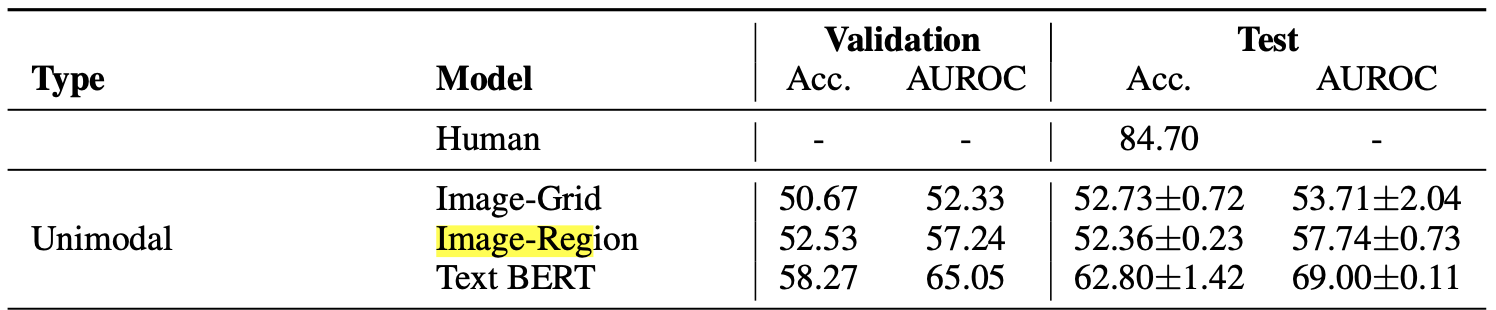
